In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import scipy.io
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [65]:
def Accuracy(compdata, data, Reconstructed):
    CR = len(compdata) / len(data)
    error = deepcopy(np.sqrt(np.sum((Reconstructed[:, 1] - data[:, 1]) ** 2)))
    energy = deepcopy(np.sqrt(np.sum((data[:, 1]) ** 2)))
    prd = error / energy
    print(f"CR: {1 / CR}")
    print(f"PRD: {prd * 100} %")

In [66]:
def ECG():
    data = scipy.io.loadmat('/content/drive/MyDrive/Depo/PhysioNet/223m (6).mat')['val'][0][0:500]
    data = data.reshape(-1, 1)
    x = np.arange(0, len(data), 1).reshape(-1, 1)
    data = np.append(x, data, axis= 1)
    return data

In [67]:
def Reconstruct(compdata, data):
    noncomp = [element for element in data[:, 0] if element not in compdata[:, 0]]
    interpolate = []
    for x in noncomp:
        y = EstimateY(x, compdata)
        interpolate.append([x, y])

    interpolate = np.array(interpolate).reshape(-1, 2)
    Reconstructed = np.append(interpolate, compdata, axis = 0)
    Reconstructed = Reconstructed[Reconstructed[:, 0].argsort()]
    return Reconstructed

In [68]:
def EstimateY(x, compdata):
    upper, lower = Bounds(x, compdata)
    slope = (upper[1] - lower[1])/(upper[0] - lower[0])
    datapointY = slope * (x - lower[0]) + lower[1]
    return datapointY


In [69]:
def Bounds(datapoint, compdata):
    upper = data[-1]
    lower = data[0]
    for i in range(len(compdata)):
        if compdata[i, 0] > datapoint:
            upper = deepcopy(compdata[i])
            break
    for i in range(len(compdata)):
        if compdata[len(compdata) - i - 1, 0] < datapoint:
            lower = deepcopy(compdata[len(compdata) - i - 1])
            break
    return upper, lower

In [70]:
def SwapToFarthest(start, finish, data, threshold):
    x0 = data[start]
    xn = data[finish]
    xs = [x0[0], xn[0]]
    ys= [x0[1], xn[1]]

    slope = (xn[1] - x0[1] )/ (xn[0] - x0[0])
    line = []
    
    for x in data[start:finish + 1, 0]:
        line.append([x, slope * x + x0[1]])
    
    line = np.array(line).reshape(-1, 2)


    distances = deepcopy(np.abs(data[start:finish + 1, 1] - line[:, 1]))
    farthest = np.argmax(distances)
    isover = np.max(distances) < threshold

    return farthest, isover, line

In [71]:
def CompressData(data, threshold):
    datalength = data[-1, 0]
    checkpoints = []
    checkpoints.append(data[0])

    while(len(data) > 0):
        start = 0
        finish = data[-1, 0]
        isover = False


        while(isover == False):
            farthest, isover, line = SwapToFarthest(start, finish, data, threshold)
            finish = deepcopy(farthest)
 
        checkpoint = deepcopy(line[-1, 0]).astype(int)
        checkpoints.append([checkpoints[-1][0] + data[checkpoint][0], data[checkpoint][1]])
        data = data[checkpoint+1:]
        data[:, 0] =  data[:, 0] - (checkpoint+1)

    checkpoints = np.array(checkpoints).reshape(-1, 2)

    complength = checkpoints[-1, 0]
    scale = datalength / complength

    checkpoints[:, 0] = deepcopy(checkpoints[:, 0] * scale)
    return checkpoints


In [72]:
def EEG():
    data = np.array(pd.read_csv('/content/drive/MyDrive/Depo/PhysioNet/Auditory evoked potential EEG-Biometric dataset2.csv', header=None))[0:500]
    scaler.fit(data)
    data = scaler.transform(data)
    data = data * 1000
    x = np.arange(0, len(data), 1).reshape(-1, 1).astype(int)
    data = np.append(x, data.astype(int), axis= 1)
    return data

In [73]:
data = ECG()

Text(0.5, 1.0, 'Original Signal')

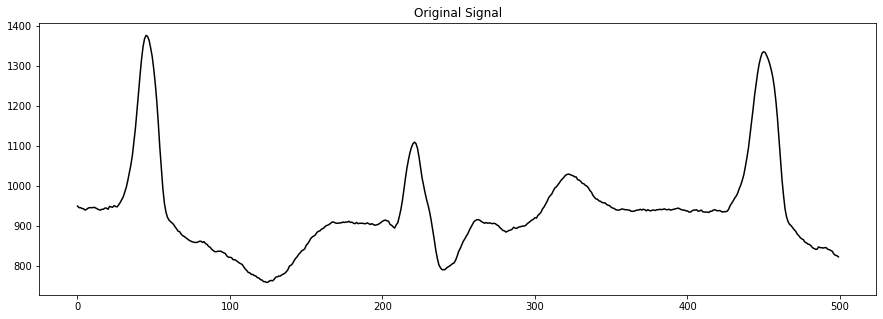

In [74]:
plt.figure(figsize= (15, 5))
plt.plot(data[:, 0], data[:, 1], c= 'black')
plt.title('Original Signal')

In [75]:
threshold = 8
compdata = CompressData(data, threshold)

Text(0.5, 1.0, 'Compressed Signal')

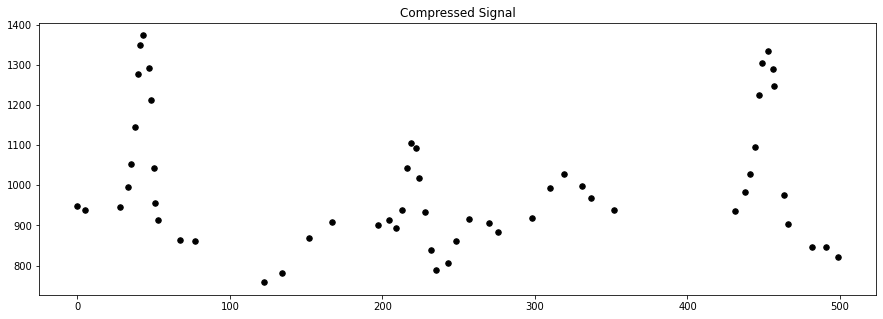

In [76]:
plt.figure(figsize= (15, 5))
plt.scatter(compdata[:, 0], compdata[:, 1], s= 30, c= 'black')
plt.title('Compressed Signal')

In [77]:
data = ECG()
Reconstructed =  Reconstruct(compdata, data)

Text(0.5, 1.0, 'Reconstructed Signal')

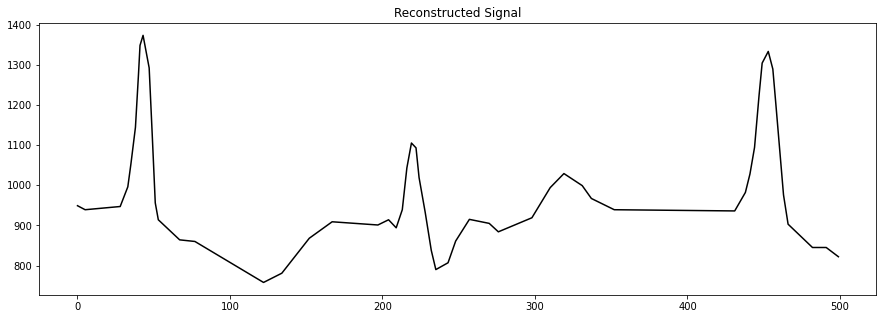

In [78]:
plt.figure(figsize= (15, 5))
plt.plot(Reconstructed[:, 0], Reconstructed[:, 1],  c= 'black')
plt.title('Reconstructed Signal')

In [79]:
Accuracy(compdata, data, Reconstructed)

CR: 8.928571428571429
PRD: 3.7631613161928867 %


In [80]:
data = EEG()
compdata = CompressData(data, 1)
data = EEG()
Reconstructed = Reconstruct(compdata, data)

Text(0.5, 1.0, 'Original Signal')

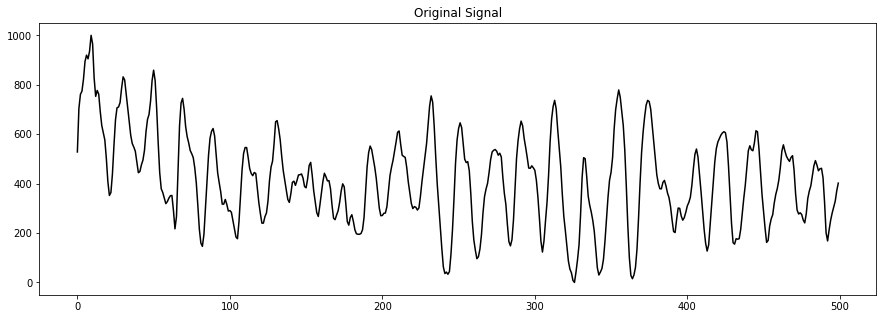

In [81]:
plt.figure(figsize= (15, 5))
plt.plot(data[:, 0], data[:, 1], c= 'black')
plt.title('Original Signal')

Text(0.5, 1.0, 'compressed data')

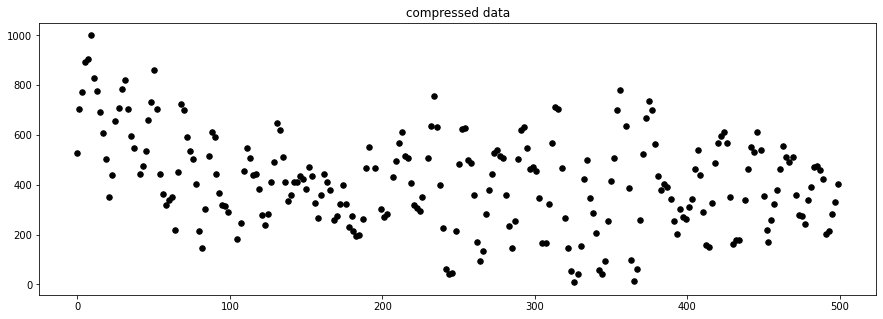

In [82]:
plt.figure(figsize= (15, 5))
plt.scatter(compdata[:, 0], compdata[:, 1], s= 30, c= 'black')
plt.title('compressed data')

Text(0.5, 1.0, 'reconstructed data')

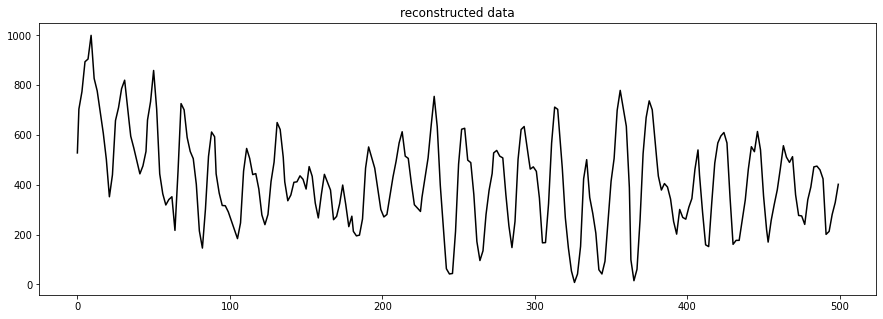

In [83]:
plt.figure(figsize= (15, 5))
plt.plot(Reconstructed[:, 0], Reconstructed[:, 1], c = 'black')
plt.title('reconstructed data')

In [84]:
Accuracy(compdata, data, Reconstructed)

CR: 2.032520325203252
PRD: 13.14478014018185 %
